In [4]:
import numpy as np
import matplotlib.pylab as plt
import sys
sys.path.insert(0, '../../src/kf')
from kf import KF
from trajectory import trajectory
np.set_printoptions(precision=2)

# 2D target tracking - CVM

CVM - Constant Velocity Model - is a popular model for taget tracking. 

Our goal is the filtration of the 2D location of a moving object. All we have are some noisy observations of the location coordinates $[y_{1,t}, y_{2,t}]^\intercal$.

We want to sequentially estimate true location coordinates $x_1$ and $x_2$, and related velocities:

$$
x_t =
\begin{bmatrix}
x_{1,t} \\ 
x_{2,t} \\ 
v_{x_1,t} \\ 
v_{x_2,t} \\
\end{bmatrix}
$$

CVM assumes the following model (for the first coordinate):

$$
\begin{aligned}
x_{1,t} &= x_{1,t-1} + v_{x_1,t-1} \Delta_t + w_{x_1,t}, \\
v_{x_1,t} &= v_{x_1, t-1} + w_{vx_1, t}.
\end{aligned}
$$

The same holds for the second coordinate.

---
**Task: Discuss model properties. Why _constant_ velocity model?**

---

**Task: Construct SSM & determine $A, B, H$:**


$$
\begin{aligned}
x_t &\sim \mathcal{N}(Ax_{t-1} + Bu_t, Q),\\
y_t &\sim \mathcal{N}(Hx_{t}, R).
\end{aligned}
$$

Tuning the covariance matrices may be a tedious task. Let's assume that we know them:

\begin{align*}
    A &=?
%    \begin{bmatrix}
%       1 & 0 & dt & 0 \\
%       0 & 1 & 0 & dt \\
%       0 & 0 & 1 &  0 \\
%       0 & 0 & 0 &  1 
%    \end{bmatrix},
    \quad
    &Q &= q\cdot
    \begin{bmatrix}
        \frac{dt^3}{3}    & 0                 & \frac{dt^{2}}{2}  & 0  \\
        0                 & \frac{dt^3}{3}    & 0                 & \frac{dt^{2}}{2} \\
        \frac{dt^{2}}{2}  & 0                 & dt                & 0 \\
        0                 & \frac{dt^{2}}{2}  & 0                 & dt
    \end{bmatrix}
    \notag \\
    H &=?
%    \begin{bmatrix}
%        1 & 0 &0 & 0 \\
%        0 & 1 &0 & 0
%    \end{bmatrix}
    \quad
    &R &=
    r^{2}\cdot
    \begin{bmatrix}
        1 & 0 \\
        0 & 1
    \end{bmatrix}
\end{align*}
where $dt = 1$, $q = .5$, $r=3$.

In [8]:
q = .5
dt = 1
r = 3.
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1,  0],
              [0, 0, 0,  1]])
Q = q * np.array([[dt**3/3, 0      , dt**2/2, 0      ],
                  [0,       dt**3/3, 0,       dt**2/2],
                  [dt**2/2, 0,       dt,      0      ],
                  [0,       dt**2/2, 0,       dt     ]])
H = np.array([[1., 0, 0, 0],
              [0., 1, 0, 0]])
R = r**2 * np.eye(2)

**Task: substitute the day and month of your birth for `code`. The `traj` object will contain the trajectory (100 measurements row-wise). Plot it with crosses.**

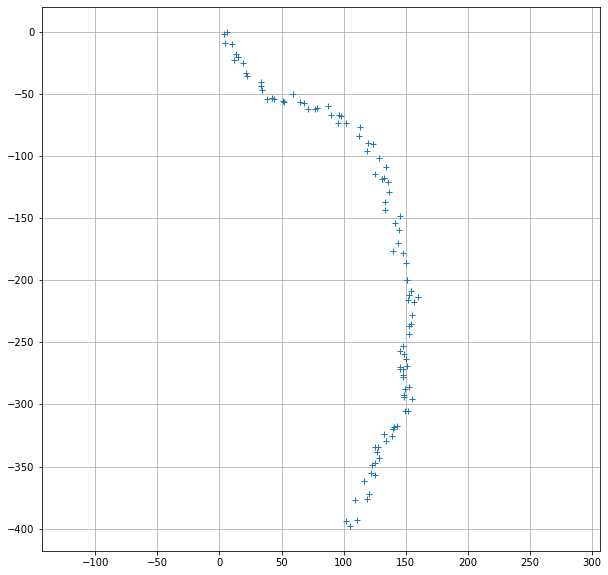

In [9]:
code = 1806
traj = trajectory(code)
plt.figure(figsize=(10, 10))
plt.plot(traj.Y[0,:], traj.Y[1,:], '+')
plt.axis('equal')
plt.show()

KF is the class of the Kalman filter. We simply "feed" it by rows in `traj.Y.T`

In [10]:
kf = KF(A=A, B=None, H=H, R=R, Q=Q)

for t, yt in enumerate(traj.Y.T):
    kf.predict()
    kf.update(yt)
    kf.log()

log_x = np.array(kf.log_x).T      # Here are the estimates

Let's plot the true trajectory of $[x_{1,t}, x_{2,t}]^\intercal$, our noisy observations $[y_]

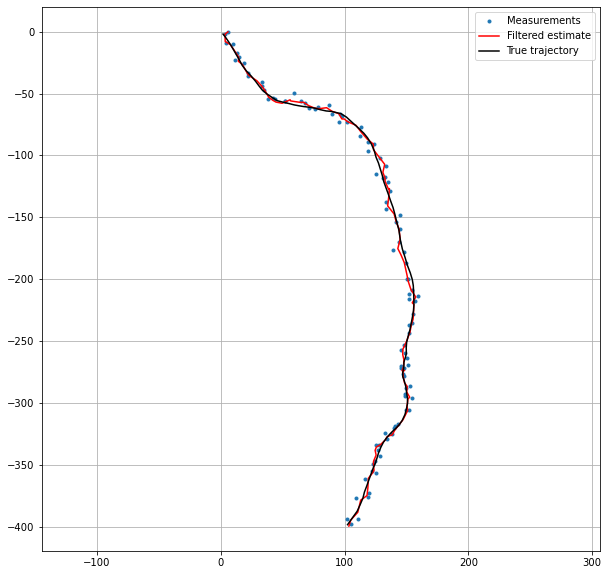

In [11]:
plt.figure(figsize=(10,10))
plt.plot(traj.Y[0,:], traj.Y[1,:], '.', label='Measurements')
plt.plot(log_x[0,:], log_x[1,:], '-', color='red', label='Filtered estimate')
plt.plot(traj.X[0,:], traj.X[1,:], 'k', label='True trajectory')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

Now, let's look at the estimates of the true velocities:

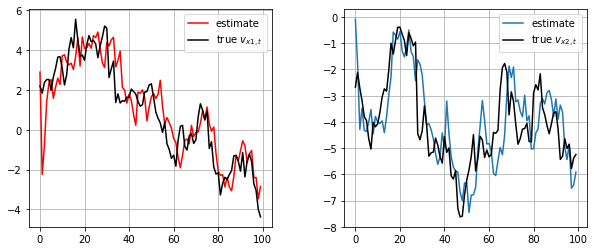

In [21]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(log_x[2,:], 'r', label='estimate')
plt.plot(traj.X[2,:], 'k', label=r'true $v_{x1,t}$')
plt.legend()
plt.subplot(1,2,2)
plt.plot(log_x[3,:], label='estimate')
plt.plot(traj.X[3,:], 'k', label=r'true $v_{x2,t}$')
plt.legend()
plt.show()

**Task: Make some conclusions. Try to play with the observation noise variance, prior distribution, and measurement dropouts.**